In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import time
import copy
from scipy.signal import find_peaks, resample
from icecream import ic
from collections import OrderedDict

from neurolib.models.aln import ALNModel
#from neurolib.models.aln import ALNModel_SaveSteps
import neurolib.utils.stimulus as stim
import neurolib.utils.functions as func  
from neurolib.utils.parameterSpace import ParameterSpace
from neurolib.optimize.exploration import BoxSearch
import os
import sys
from pynverse import inversefunc

from intersect import intersection


sys.path.insert(0, '..')
from prc_funcs import *
from functions import *
    

import matplotlib.colors as mcolors

colors = mcolors.TABLEAU_COLORS
by_hsv = sorted((tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(color))),
                         name)
                        for name, color in colors.items())
colrs = [name for hsv, name in by_hsv]

#hide
import logging
logging.getLogger().setLevel(logging.INFO)
import warnings
warnings.filterwarnings("ignore")

BASE_PATH = "../../../../" # need to go back from default hdf path "./data/hdf"
HDF_PATH = BASE_PATH + "Data/"

# **Show Timeseries of stimulated run, reference run and input**

In [2]:
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.1
aln.params['sampling_dt'] = aln.params.dt
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
prc = PRC_ALN(aln)

INFO:root:aln: Model initialized.
ic| domfreq: 21.28421052631579


initialised ...


ic| peaks: array([ 52, 522])
ic| input_delays: array([ 0.        , 23.49159248])


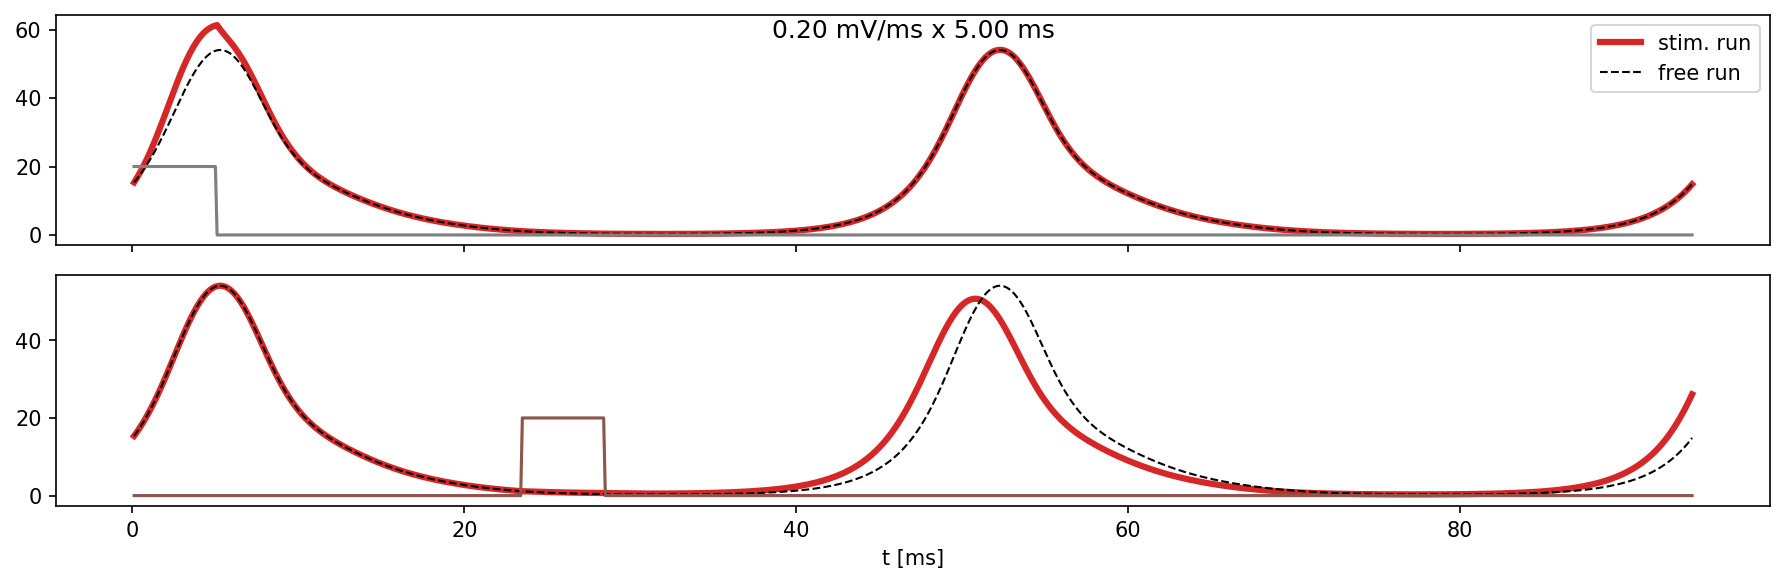

In [3]:
prc.plot_prc(
    itype="current",
    amplitude=0.2,
    stim_len=5,
    num_points=2)

INFO:root:aln: Model initialized.
ic| input_peak-f_peak_ref: 26.799999999999997
ic| lab: [0.0, 20.0, 40.0, 60.0]


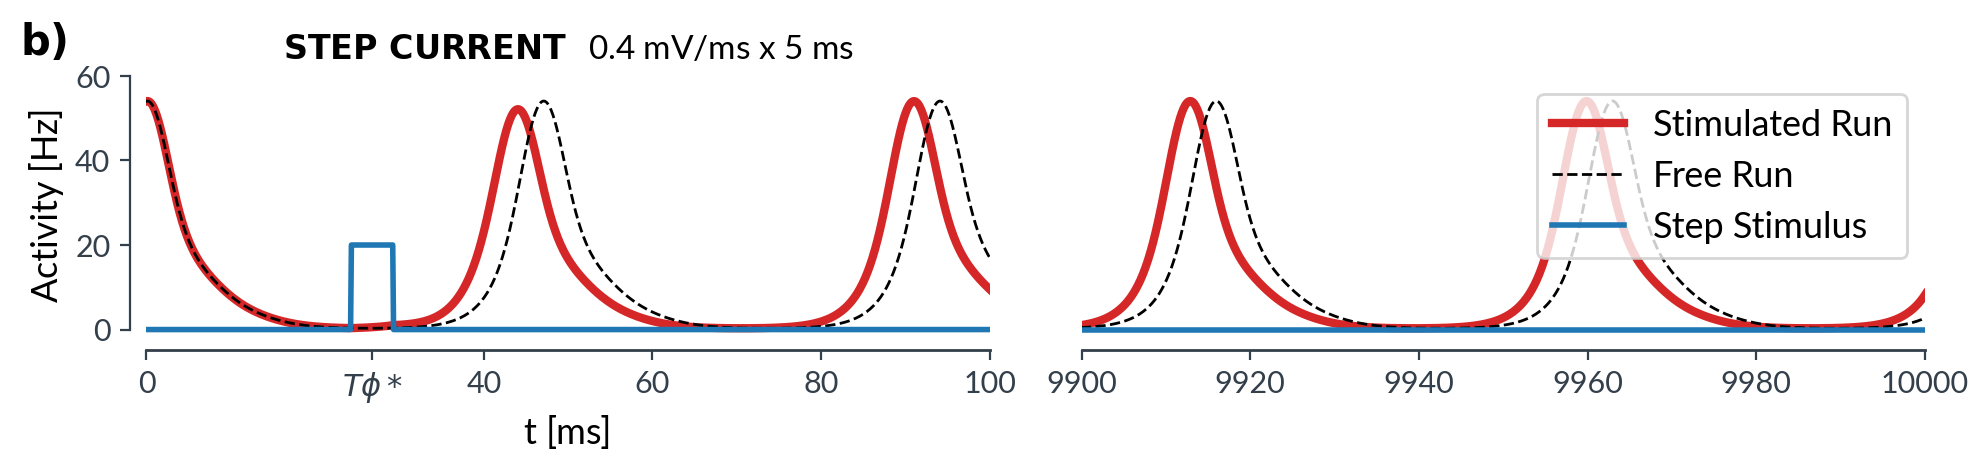

In [4]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13
fig, axs = plt.subplots(1, 2, figsize=(10, 2.5), dpi=200, sharey=True)

num_points = 1
itype = "current"
stim_type = "step"
amplitude = 0.4
stim_len = 5
delay = 40

'''
Show timeseries of stimulated system to verify phase advances/delays
'''
# run model to store state vector of a point inside LC
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.1
aln.params['sampling_dt'] = aln.params.dt
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
aln.params.duration = 11000
aln.run(continue_run=True)

# create reference deepcopy without stimulation
aln_ref = copy.deepcopy(aln)
aln_ref.params.duration = 11000
aln_ref.run()
# find peaks in reference run to determine stimulus phase
peaks, props = find_peaks(aln_ref.rates_exc[0].T, height = -20)
#ic(peaks)
f_peak_ref = peaks[0] * aln_ref.params.dt



aln2 = copy.deepcopy(aln)
aln2.params.duration = 11000

if stim_type=="sine":
    stimulus = ShiftedSinusoidalInput(
        amplitude=amplitude,
        frequency=1000 / self.frperiod,
        peak_at=delay,
        start=0,
        end=self.frperiod,
    ).as_array(aln.params.duration, aln.params.dt)

    #delay = 0 #because of the plotting
else:
    stimulus = stim.StepInput(
        step_size = amplitude, 
        start = delay, 
        end = delay+stim_len,
        n = 1
    ).as_array(aln.params.duration, aln.params.dt)

assert itype in ["current", "rate"], "input kind must be 'current' or 'rate'!"

if itype == "current":
    aln2.params["ext_exc_current"] = stimulus
elif itype == "rate":
    aln2.params["ext_exc_rate"] = stimulus * 1e-3 # convert kHz to Hz

aln2.run(continue_run=True)

peaks, props = find_peaks(aln_ref.rates_exc[0].T, prominence=3)
f_peak_ref = peaks[0] * aln_ref.params.dt

input_peak = delay + stim_len / 2.

axs[0].plot(aln2.t - f_peak_ref, aln2.rates_exc[0].T, color="tab:red", lw=3, label="Stimulated Run")
axs[0].plot(aln_ref.t - f_peak_ref, aln_ref.rates_exc[0].T, "--",color="black", lw=1, label="Free Run")
axs[0].plot(aln.t - f_peak_ref, stimulus[0]*50, lw=2, color="tab:blue",label="Step Stimulus")
axs[0].set_xlim(0, 100)

axs[1].plot(aln.t - f_peak_ref, aln2.rates_exc[0].T, color="tab:red", lw=3, label="stim. run")
axs[1].plot(aln_ref.t - f_peak_ref, aln_ref.rates_exc[0].T, "--",color="black", lw=1, label="free run")
axs[1].plot(aln.t - f_peak_ref, stimulus[0]*50, lw=2, color="tab:blue",label="step stimulus")
axs[1].set_xlim(9900, 10000)


axs[0].set_xticks([0, input_peak-f_peak_ref, 40, 60, 80, 100])
axs[0].set_xticklabels(labels=['0', r'$T\phi*$', '40', '60', '80', '100'] )
ic(input_peak-f_peak_ref)
axs[0].set_xlabel("t [ms]")
handles, labels = axs[0].get_legend_handles_labels()
axs[1].legend(handles, labels, loc="upper right")
axs[0].set_title(r'$\bf{STEP \ CURRENT}\ \ $' + "{0:.1f} mV/ms x {1:.0f} ms".format(amplitude, stim_len))

axs[0].set_ylim(-1, 60)
axs[1].set_ylim(-1, 60)


axs[0].tick_params(right=False, top=False)
axs[1].tick_params(right=False, top=False, left=False)

axs[0].spines["top"].set_visible(False), axs[0].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False), axs[1].spines["right"].set_visible(False)
axs[1].spines["left"].set_visible(False)
#ax.spines["bottom"].set_bounds(low=0, high=100)
plt.draw()
lab = [float(item.get_text().replace("−", "-")) for item in axs[0].get_yticklabels(which='both')][1:]
ic(lab)
axs[0].spines["left"].set_bounds(low=min(lab), high=max(lab))
axs[0].spines["left"].set_position(("outward", 6))
for line in ["bottom"]:
    axs[0].spines[line].set_linewidth(1)
    axs[0].spines[line].set_position(("outward",6))
    axs[1].spines[line].set_linewidth(1)
    axs[1].spines[line].set_position(("outward",6))

#axs[0].spines["left"].set_bounds(low=0, high=60)
axs[0].set_yticks([0, 20, 40, 60])
axs[0].set_yticklabels(labels=['0', '20', '40', '60'] )
axs[0].set_ylabel("Activity [Hz]")

# This is pic b)
axs[0].text(-15, 65, r"$\mathbf{b)}$", fontsize=15)

fig.tight_layout()
#fig.savefig("Pics/PRC_Method_Step_2.pdf")

INFO:root:aln: Model initialized.
ic| input_peak-f_peak_ref: 16.249999999999993
ic| lab: [0.0, 20.0, 40.0, 60.0]


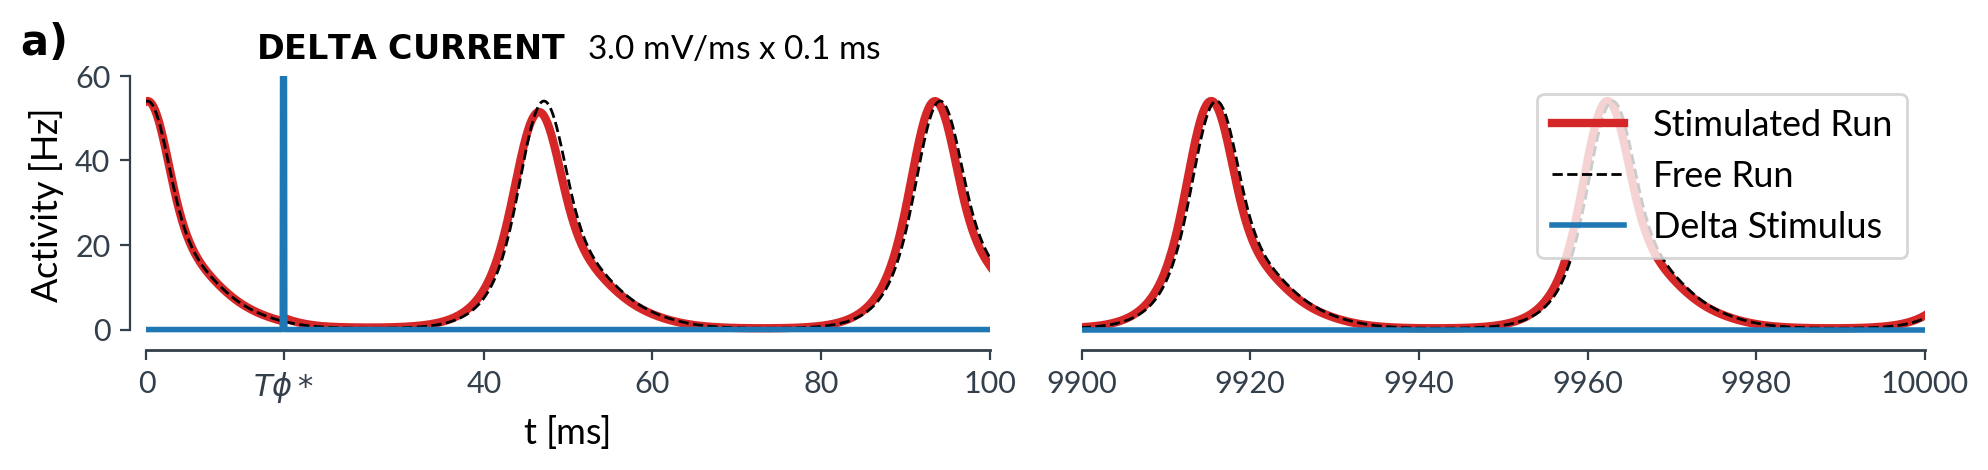

In [5]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13
fig, axs = plt.subplots(1, 2, figsize=(10, 2.5), dpi=200, sharey=True)

num_points = 1
itype = "current"
stim_type = "step"
amplitude = 3
stim_len = 0.1
delay = 50

'''
Show timeseries of stimulated system to verify phase advances/delays
'''
# run model to store state vector of a point inside LC
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.1
aln.params['sampling_dt'] = aln.params.dt
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
aln.params.duration = 11000
aln.run(continue_run=True)

# create reference deepcopy without stimulation
aln_ref = copy.deepcopy(aln)
aln_ref.params.duration = 11000
aln_ref.run()
# find peaks in reference run to determine stimulus phase
peaks, props = find_peaks(aln_ref.rates_exc[0].T, height = -20)
#ic(peaks)
f_peak_ref = peaks[0] * aln_ref.params.dt



aln2 = copy.deepcopy(aln)
aln2.params.duration = 11000

if stim_type=="sine":
    stimulus = ShiftedSinusoidalInput(
        amplitude=amplitude,
        frequency=1000 / self.frperiod,
        peak_at=delay,
        start=0,
        end=self.frperiod,
    ).as_array(aln.params.duration, aln.params.dt)

    #delay = 0 #because of the plotting
else:
    stimulus = stim.StepInput(
        step_size = amplitude, 
        start = delay, 
        end = delay+stim_len,
        n = 1
    ).as_array(aln.params.duration, aln.params.dt)

assert itype in ["current", "rate"], "input kind must be 'current' or 'rate'!"

if itype == "current":
    aln2.params["ext_exc_current"] = stimulus
elif itype == "rate":
    aln2.params["ext_exc_rate"] = stimulus * 1e-3 # convert kHz to Hz

aln2.run(continue_run=True)

peaks, props = find_peaks(aln_ref.rates_exc[0].T, prominence=3)
f_peak_ref = peaks[0] * aln_ref.params.dt

input_peak = delay + stim_len / 2.

axs[0].plot(aln2.t - f_peak_ref, aln2.rates_exc[0].T, color="tab:red", lw=3, label="Stimulated Run")
axs[0].plot(aln_ref.t - f_peak_ref, aln_ref.rates_exc[0].T, "--",color="black", lw=1, label="Free Run")
axs[0].plot(aln.t - f_peak_ref, stimulus[0]*50, lw=2, color="tab:blue",label="Delta Stimulus")
axs[0].set_xlim(0, 100)

axs[1].plot(aln.t - f_peak_ref, aln2.rates_exc[0].T, color="tab:red", lw=3, label="stim. run")
axs[1].plot(aln_ref.t - f_peak_ref , aln_ref.rates_exc[0].T, "--",color="black", lw=1, label="free run")
axs[1].plot(aln.t - f_peak_ref, stimulus[0]*50, lw=2, color="tab:blue",label="delta stimulus")
axs[1].set_xlim(9900, 10000)


axs[0].set_xticks([0, input_peak-f_peak_ref, 40, 60, 80, 100])
axs[0].set_xticklabels(labels=['0', r'$T\phi*$', '40', '60', '80', '100'] )
ic(input_peak-f_peak_ref)
axs[0].set_xlabel("t [ms]")
handles, labels = axs[0].get_legend_handles_labels()
axs[1].legend(handles, labels, loc="upper right")
axs[0].set_title(r'$\bf{DELTA \ CURRENT}\ \ $' + "{0:.1f} mV/ms x {1:.1f} ms".format(amplitude, stim_len))

axs[0].set_ylim(-1, 60)
axs[1].set_ylim(-1, 60)


axs[0].tick_params(right=False, top=False)
axs[1].tick_params(right=False, top=False, left=False)

axs[0].spines["top"].set_visible(False), axs[0].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False), axs[1].spines["right"].set_visible(False)
axs[1].spines["left"].set_visible(False)
#ax.spines["bottom"].set_bounds(low=0, high=100)
plt.draw()
lab = [float(item.get_text().replace("−", "-")) for item in axs[0].get_yticklabels(which='both')][1:]
ic(lab)
axs[0].spines["left"].set_bounds(low=min(lab), high=max(lab))
axs[0].spines["left"].set_position(("outward", 6))
for line in ["bottom"]:
    axs[0].spines[line].set_linewidth(1)
    axs[0].spines[line].set_position(("outward",6))
    axs[1].spines[line].set_linewidth(1)
    axs[1].spines[line].set_position(("outward",6))

#axs[0].spines["left"].set_bounds(low=0, high=60)
axs[0].set_yticks([0, 20, 40, 60])
axs[0].set_yticklabels(labels=['0', '20', '40', '60'] )
axs[0].set_ylabel("Activity [Hz]")

# This is pic a)
axs[0].text(-15, 65, r"$\mathbf{a)}$", fontsize=15)


fig.tight_layout()
#fig.savefig("Pics/PRC_Method_Delta_2.pdf")

In [6]:
def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique), loc=1)


INFO:root:aln: Model initialized.
ic| input_peak: 60.0
ic| input_peak - f_peak_ref: 30.5
ic| lab: [0.0, 20.0, 40.0, 60.0]


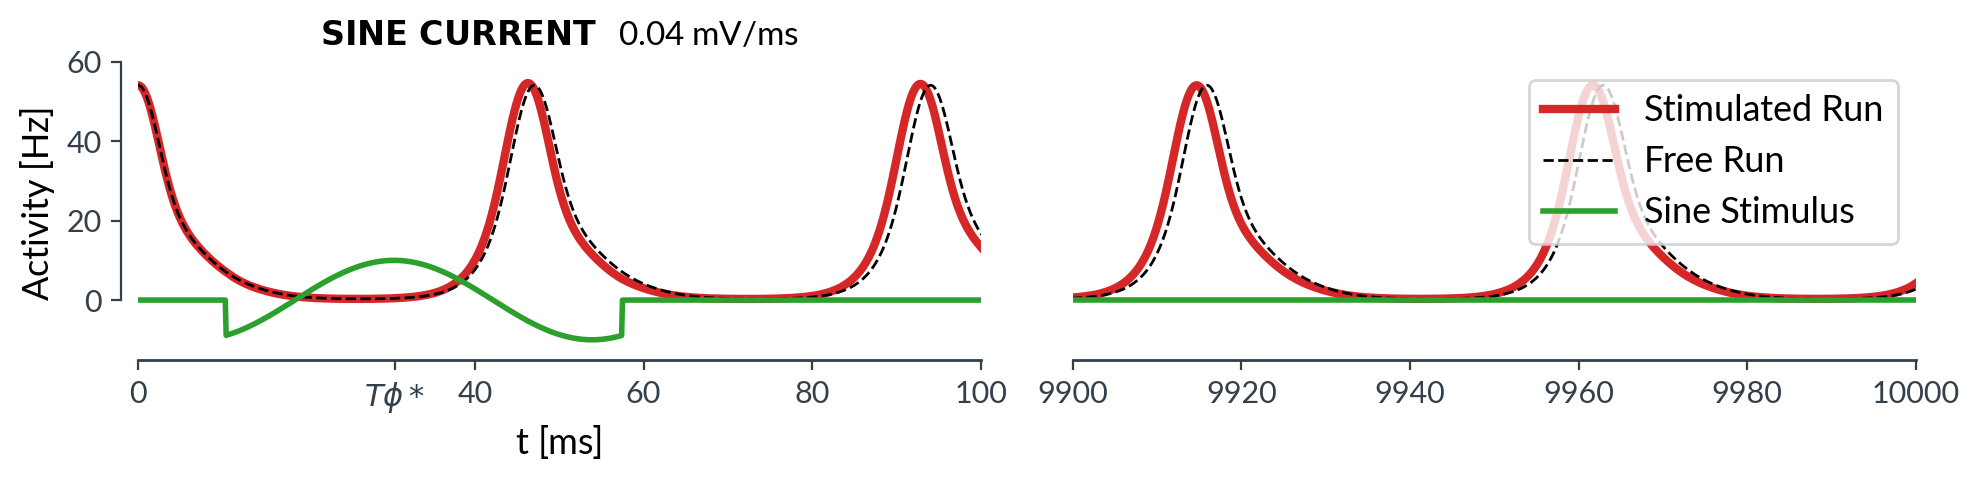

In [7]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13
fig, axs = plt.subplots(1, 2, figsize=(10, 2.5), dpi=200, sharey=True)

num_points = 1
itype = "current"
stim_type = "sine"
amplitude = 0.04
#stim_len = 5
delay = 20.

'''
Show timeseries of stimulated system to verify phase advances/delays
'''
# run model to store state vector of a point inside LC
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.1
aln.params['sampling_dt'] = aln.params.dt
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.
aln.params.duration = 11000
aln.run(continue_run=True)

# create reference deepcopy without stimulation
aln_ref = copy.deepcopy(aln)
aln_ref.params.duration = 11000
aln_ref.run()
# find peaks in reference run to determine stimulus phase
peaks, props = find_peaks(aln_ref.rates_exc[0].T, height = -20)
#ic(peaks)
f_peak_ref = peaks[0] * aln_ref.params.dt


aln2 = copy.deepcopy(aln)
aln2.params.duration = 11000

if stim_type=="sine":
    stimulus = ShiftedSinusoidalInput(
        amplitude=amplitude,
        frequency=1000 / prc.frperiod,
        peak_at=delay,
        start=40,
        end=40+prc.frperiod,
    ).as_array(aln.params.duration, aln.params.dt)

    #delay = 0 #because of the plotting
else:
    stimulus = stim.StepInput(
        step_size = amplitude, 
        start = delay, 
        end = delay+stim_len,
        n = 1
    ).as_array(aln.params.duration, aln.params.dt)

assert itype in ["current", "rate"], "input kind must be 'current' or 'rate'!"

if itype == "current":
    aln2.params["ext_exc_current"] = stimulus
elif itype == "rate":
    aln2.params["ext_exc_rate"] = stimulus * 1e-3 # convert kHz to Hz

aln2.run(continue_run=True)

peaks, props = find_peaks(aln_ref.rates_exc[0].T, prominence=3)
f_peak_ref = peaks[0] * aln_ref.params.dt

input_peak = 40 + delay 
ic(input_peak)
axs[0].plot(aln2.t - f_peak_ref, aln2.rates_exc[0].T, color="tab:red", lw=3, label="Stimulated Run")
axs[0].plot(aln_ref.t - f_peak_ref, aln_ref.rates_exc[0].T, "--",color="black", lw=1, label="Free Run")
axs[0].plot(aln2.t - f_peak_ref, stimulus[0]*250, lw=2, color="tab:green",label="Sine Stimulus")
axs[0].set_xlim(0, 100)

axs[1].plot(aln2.t - f_peak_ref, aln2.rates_exc[0].T, color="tab:red", lw=3, label="Stimulated Run")
axs[1].plot(aln_ref.t - f_peak_ref, aln_ref.rates_exc[0].T, "--",color="black", lw=1, label="Free Run")
axs[1].plot(aln2.t - f_peak_ref, stimulus[0]/2, lw=2, color="tab:green",label="Sine Stimulus")
axs[1].set_xlim(9900, 10000)


axs[0].set_xticks([0, input_peak-f_peak_ref, 40, 60, 80, 100])
axs[0].set_xticklabels(labels=['0', r'$T\phi*$', '40', '60', '80', '100'] )
ic(input_peak - f_peak_ref)
axs[0].set_xlabel("t [ms]")
axs[1].legend(loc="upper right")
axs[0].set_title(r'$\bf{SINE \ CURRENT}\ \ $' + "{0:.2f} mV/ms".format(amplitude))

axs[0].set_ylim(-11, 60)
axs[1].set_ylim(-11, 60)


axs[0].tick_params(right=False, top=False)
axs[1].tick_params(right=False, top=False, left=False)

axs[0].spines["top"].set_visible(False), axs[0].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False), axs[1].spines["right"].set_visible(False)
axs[1].spines["left"].set_visible(False)
#ax.spines["bottom"].set_bounds(low=0, high=100)
plt.draw()
lab = [float(item.get_text().replace("−", "-")) for item in axs[0].get_yticklabels(which='both')][1:]
ic(lab)
axs[0].spines["left"].set_bounds(low=min(lab), high=max(lab))
axs[0].spines["left"].set_position(("outward", 6))
for line in ["bottom"]:
    axs[0].spines[line].set_linewidth(1)
    axs[0].spines[line].set_position(("outward",6))
    axs[1].spines[line].set_linewidth(1)
    axs[1].spines[line].set_position(("outward",6))

#axs[0].spines["left"].set_bounds(low=0, high=60)
axs[0].set_yticks([0, 20, 40, 60])
axs[0].set_yticklabels(labels=['0', '20', '40', '60'] )
axs[0].set_ylabel("Activity [Hz]")
fig.tight_layout()
#fig.savefig("Pics/PRC_Method_Sine.pdf")

INFO:root:aln: Model initialized.
ic| input_peak-f_peak_ref: 50.09159248269041
ic| lab: [0.0, 20.0, 40.0, 60.0]


Text(-15, 65, '$\\mathbf{c)}$')

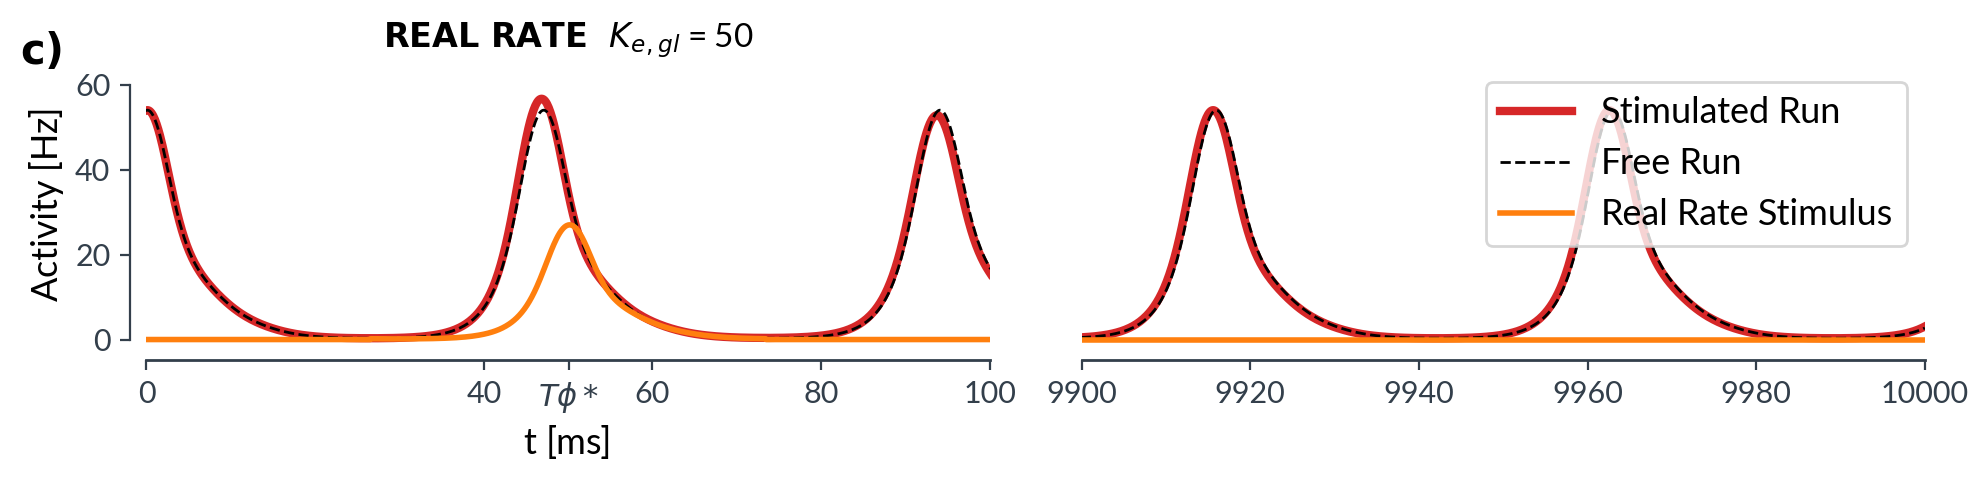

In [8]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

num_points = 1
itype = "real"
Ke_gl = 50
#stim_len = 5
delay = 30.
'''
Show timeseries of stimulated system to verify phase advances/delays
'''
# run model to store state vector of a point inside LC
# run model to store state vector of a point inside LC
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.1
aln.params['sampling_dt'] = aln.params.dt
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.

aln.params.duration = 11000
aln.run(continue_run=True)

# create reference deepcopy without stimulation
aln_ref = copy.deepcopy(aln)
aln_ref.params.duration = 11000
aln_ref.run()

fig, axs = plt.subplots(1, 2, figsize=(10, 2.5), dpi=200, sharey=True)

aln2 = copy.deepcopy(aln)
aln2.params.duration = 11000
aln2.params.Ke_gl = Ke_gl

stimulus = ALNRatesStimulus(
    start = delay,
    #start = int(0.5*self.frperiod) + delay,
    rates = prc.frcycle, 
    frperiod = prc.frperiod
).as_array(aln.params.duration, aln.params.dt)

aln2.params["ext_exc_rate"] = stimulus * 1e-3 # convert Hz to kHz

aln2.run(continue_run=True)

peaks, props = find_peaks(aln_ref.rates_exc[0].T, prominence=3)
f_peak_ref = peaks[0] * aln_ref.params.dt
s_peak_ref = peaks[1] * aln_ref.params.dt
t_peak_ref = peaks[2] * aln_ref.params.dt

stim_len = prc.frperiod / 2
input_peak = delay + stim_len
if input_peak < f_peak_ref:
    phase_t = prc.frperiod - (f_peak_ref - input_peak) # period - time to period end
elif input_peak < s_peak_ref:
    phase_t = prc.frperiod - (s_peak_ref - input_peak)
elif input_peak < t_peak_ref:
    phase_t = prc.frperiod - (t_peak_ref - input_peak)
else: 
    print("ERROR: stimulus delay > freerunning period")
    ic(delay, self.frperiod)

axs[0].plot(aln2.t - f_peak_ref, aln2.rates_exc[0].T, color="tab:red", lw=3, label="stimulated run")
axs[0].plot(aln_ref.t - f_peak_ref, aln_ref.rates_exc[0].T, "--",color="black", lw=1, label="free run")
axs[0].plot(aln2.t - f_peak_ref, stimulus[0]/2, lw=2,  color="tab:orange",label="real rate stimulus")
axs[0].set_xlim(0, 100)

axs[1].plot(aln2.t - f_peak_ref, aln2.rates_exc[0].T, color="tab:red", lw=3, label="Stimulated Run")
axs[1].plot(aln_ref.t - f_peak_ref, aln_ref.rates_exc[0].T, "--",color="black", lw=1, label="Free Run")
axs[1].plot(aln2.t - f_peak_ref, stimulus[0]/2, lw=2, color="tab:orange",label="Real Rate Stimulus")
axs[1].set_xlim(9900, 10000)

axs[0].set_xlabel("t [ms]")
axs[0].set_title(r'$\bf{REAL \ RATE}$' + r"$\ \ K_{e,gl}$ = 50")
axs[0].set_ylim(-1, 65)

axs[0].set_xticks([0, input_peak-f_peak_ref, 40, 60, 80, 100])
ic(input_peak-f_peak_ref)
axs[0].set_xticklabels(labels=['0', r'$T\phi*$', '40', '60', '80', '100'] )
axs[1].set_ylim(-1, 65)
axs[1].legend(loc="upper right")

axs[0].tick_params(right=False, top=False)
axs[1].tick_params(right=False, top=False, left=False)

axs[0].spines["top"].set_visible(False), axs[0].spines["right"].set_visible(False)
axs[1].spines["top"].set_visible(False), axs[1].spines["right"].set_visible(False)
axs[1].spines["left"].set_visible(False)
#ax.spines["bottom"].set_bounds(low=0, high=100)
plt.draw()
lab = [float(item.get_text().replace("−", "-")) for item in axs[0].get_yticklabels(which='both')][1:-1]
ic(lab)
axs[0].spines["left"].set_bounds(low=min(lab), high=max(lab))
axs[0].spines["left"].set_position(("outward", 6))
for line in ["bottom"]:
    axs[0].spines[line].set_linewidth(1)
    axs[0].spines[line].set_position(("outward",6))
    axs[1].spines[line].set_linewidth(1)
    axs[1].spines[line].set_position(("outward",6))

#axs[0].spines["left"].set_bounds(low=0, high=60)
axs[0].set_yticks([0, 20, 40, 60])
axs[0].set_yticklabels(labels=['0', '20', '40', '60'] )
axs[0].set_ylabel("Activity [Hz]")
fig.tight_layout()

# This is pic c)
axs[0].text(-15, 65, r"$\mathbf{c)}$", fontsize=15)

#fig.savefig("Pics/PRC_Method_Real_2.pdf")

INFO:root:aln: Model initialized.
ic| input_peak-f_peak_ref: 7.891592482690406
ic| lab: [0.0, 20.0, 40.0, 60.0]


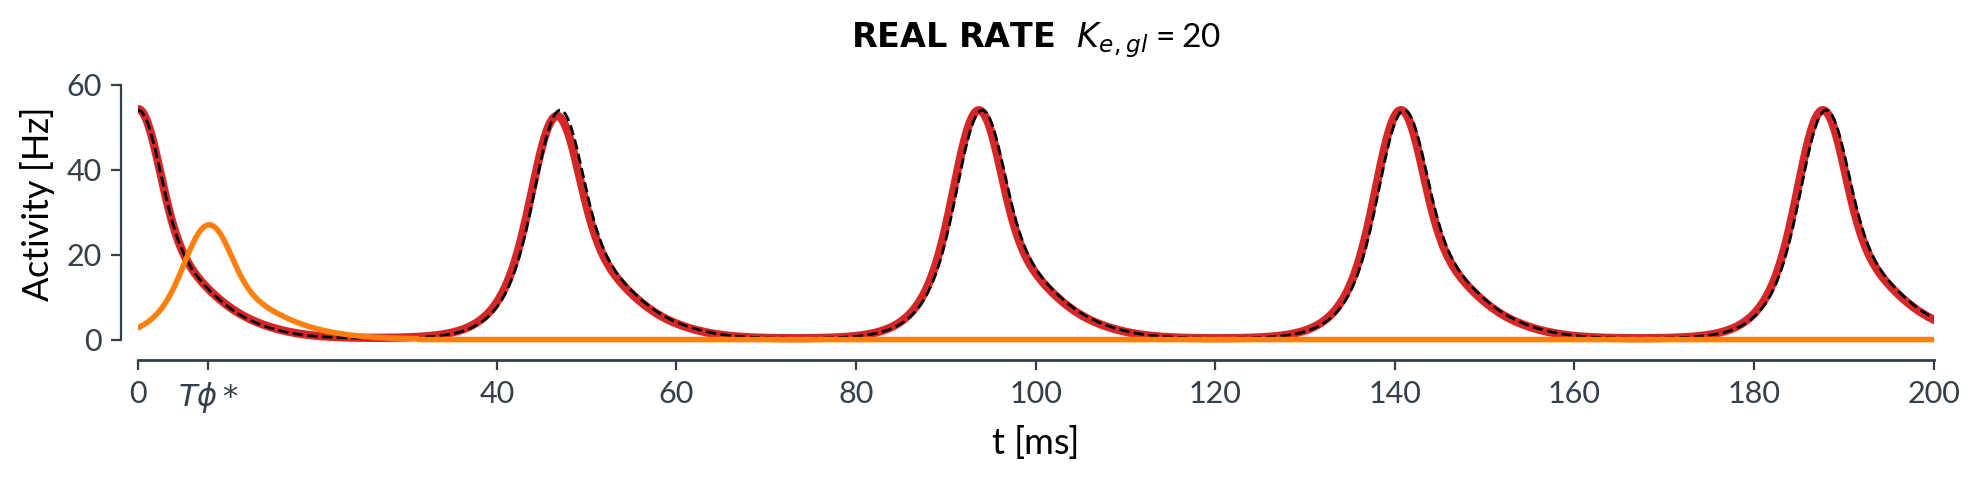

In [9]:
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Lato'
plt.rcParams['axes.edgecolor']='#333F4B'
plt.rcParams['axes.linewidth']=0.8
plt.rcParams['xtick.color']='#333F4B'
plt.rcParams['ytick.color']='#333F4B'
plt.rcParams['axes.labelsize']=13
plt.rcParams['xtick.labelsize']=11
plt.rcParams['ytick.labelsize']=11
plt.rcParams['legend.fontsize'] = 13

num_points = 1
itype = "real"
Ke_gl = 20
#stim_len = 5
delay = 30.
'''
Show timeseries of stimulated system to verify phase advances/delays
'''
# run model to store state vector of a point inside LC
# run model to store state vector of a point inside LC
aln = ALNModel()
aln.params['mue_ext_mean'] = 1.1
aln.params['mui_ext_mean'] = 0.5
aln.params['dt'] = 0.1
aln.params['sampling_dt'] = aln.params.dt
aln.params['a'] = 0.
aln.params['b'] = 0.
aln.params['sigma_ou'] = 0.

aln.params.duration = 10000
aln.run(continue_run=True)

# create reference deepcopy without stimulation
aln_ref = copy.deepcopy(aln)
aln_ref.params.duration = 10000
aln_ref.run()

fig, ax = plt.subplots(1, 1, figsize=(10, 2.5), dpi=200, sharey=True)

aln2 = copy.deepcopy(aln)
aln2.params.duration = 10000
aln2.params.Ke_gl = Ke_gl

stimulus = ALNRatesStimulus(
    start = delay,
    #start = int(0.5*self.frperiod) + delay,
    rates = prc.frcycle, 
    frperiod = prc.frperiod
).as_array(aln.params.duration, aln.params.dt)

aln2.params["ext_exc_rate"] = stimulus * 1e-3 # convert Hz to kHz

aln2.run(continue_run=True)

peaks, props = find_peaks(aln_ref.rates_exc[0].T, prominence=3)
f_peak_ref = peaks[0] * aln_ref.params.dt
s_peak_ref = peaks[1] * aln_ref.params.dt
t_peak_ref = peaks[2] * aln_ref.params.dt

stim_len = prc.frperiod / 2
input_peak = delay + stim_len
if input_peak < f_peak_ref:
    phase_t = prc.frperiod - (f_peak_ref - input_peak) # period - time to period end
elif input_peak < s_peak_ref:
    phase_t = prc.frperiod - (s_peak_ref - input_peak)
elif input_peak < t_peak_ref:
    phase_t = prc.frperiod - (t_peak_ref - input_peak)
else: 
    print("ERROR: stimulus delay > freerunning period")
    ic(delay, self.frperiod)

ax.plot(aln2.t - f_peak_ref, aln2.rates_exc[0].T, color="tab:red", lw=3, label="stimulated run")
ax.plot(aln_ref.t - f_peak_ref, aln_ref.rates_exc[0].T, "--",color="black", lw=1, label="free run")
ax.plot(aln2.t - f_peak_ref, stimulus[0]/2, lw=2,  color="tab:orange",label="real rate stimulus")
ax.set_xlim(0, 200)

#axs[1].plot(aln2.t , aln2.rates_exc[0].T, color="tab:red", lw=3, label="Stimulated Run")
#axs[1].plot(aln_ref.t , aln_ref.rates_exc[0].T, ¶"--",color="black", lw=1, label="Free Run")
#axs[1].plot(aln2.t, stimulus[0]/2, lw=2, color="tab:orange",label="Real Rate Stimulus")
#axs[1].set_xlim(9900, 10000)

ax.set_xlabel("t [ms]")
ax.set_title(r'$\bf{REAL \ RATE}$' + r"$\ \ K_{e,gl}$ = 20")
ax.set_ylim(-1, 65)

ax.set_xticks([0, input_peak-f_peak_ref, 40, 60, 80, 100, 120, 140, 160, 180, 200])
ic(input_peak-f_peak_ref)
ax.set_xticklabels(labels=['0', r'$T\phi*$', '40', '60', '80', '100', '120', '140', '160', '180', '200'] )
#axs[1].set_ylim(-1, 65)
#axs[1].legend(loc="upper right")

ax.tick_params(right=False, top=False)
#axs[1].tick_params(right=False, top=False, left=False)

ax.spines["top"].set_visible(False), ax.spines["right"].set_visible(False)
#axs[1].spines["top"].set_visible(False), axs[1].spines["right"].set_visible(False)
#axs[1].spines["left"].set_visible(False)
#ax.spines["bottom"].set_bounds(low=0, high=100)
plt.draw()
lab = [float(item.get_text().replace("−", "-")) for item in axs[0].get_yticklabels(which='both')]
ic(lab)
ax.spines["left"].set_bounds(low=min(lab), high=max(lab))
ax.spines["left"].set_position(("outward", 6))
for line in ["bottom"]:
    ax.spines[line].set_linewidth(1)
    ax.spines[line].set_position(("outward",6))
    #axs[1].spines[line].set_linewidth(1)
    #axs[1].spines[line].set_position(("outward",6))

#axs[0].spines["left"].set_bounds(low=0, high=60)
ax.set_yticks([0, 20, 40, 60])
ax.set_yticklabels(labels=['0', '20', '40', '60'] )
ax.set_ylabel("Activity [Hz]")
fig.tight_layout()
#fig.savefig("Pics/PRC_Method_Real.pdf")